Importing packages

In [ ]:
import keras
import pickle
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt


Loading pickle file

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/BDA work/AI project/"
X = pickle.load(open(path +'X.pickle','rb'))
y = pickle.load(open(path +'y.pickle','rb'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train, test split

In [ ]:
X_train, X_test, y_train_org, y_test_org = train_test_split(X, y, test_size=0.3, random_state=56)

Pre-processing

In [ ]:
x_train_preprocessed = preprocess_input(X_train)
x_test_preprocessed = preprocess_input(X_test)

Changing Y to categories

In [ ]:
y_train = to_categorical(y_train_org)
y_test = to_categorical(y_test_org)

Resnet model

In [ ]:
resnet_model = ResNet50(weights='imagenet')
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Getting output of the avg_pool layer

In [ ]:
last_layer = resnet_model.get_layer("avg_pool")
resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)

Model


In [ ]:
new_model=Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(5, activation="sigmoid"))
new_model.layers[0].trainable=False
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
new_model.fit(x_train_preprocessed, y_train,batch_size=8,epochs=7,validation_data=(x_test_preprocessed, y_test))

Epoch 1/7
87/87 [==============================] - 10s 61ms/step - loss: 1.8254 - accuracy: 0.3052 - val_loss: 1.3369 - val_accuracy: 0.4530
Epoch 2/7
87/87 [==============================] - 4s 43ms/step - loss: 1.0318 - accuracy: 0.6092 - val_loss: 1.1997 - val_accuracy: 0.5101
Epoch 3/7
87/87 [==============================] - 4s 43ms/step - loss: 0.8247 - accuracy: 0.6887 - val_loss: 1.2254 - val_accuracy: 0.5268
Epoch 4/7
87/87 [==============================] - 4s 43ms/step - loss: 0.5629 - accuracy: 0.8338 - val_loss: 1.3052 - val_accuracy: 0.5268
Epoch 5/7
87/87 [==============================] - 4s 43ms/step - loss: 0.5124 - accuracy: 0.8520 - val_loss: 1.2946 - val_accuracy: 0.5369
Epoch 6/7
87/87 [==============================] - 4s 44ms/step - loss: 0.3822 - accuracy: 0.8919 - val_loss: 1.3041 - val_accuracy: 0.5336
Epoch 7/7
87/87 [==============================] - 4s 44ms/step - loss: 0.3531 - accuracy: 0.9166 - val_loss: 1.2972 - val_accuracy: 0.5570


Saving model as json file

In [ ]:
from keras.models import model_from_json
model_json = new_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
new_model.save_weights("model.h5")
print("Saved model")


Saved model


Confusion matrix

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


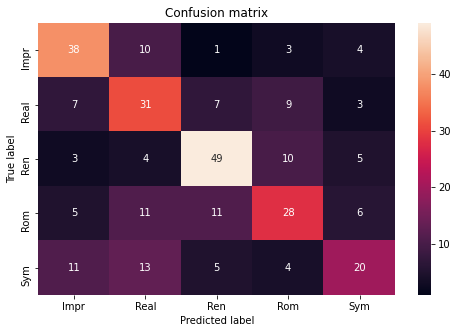

In [ ]:
y_pred = new_model.predict_classes(x_test_preprocessed)
cm = confusion_matrix(y_test_org, y_pred) 
cm_df = pd.DataFrame(cm,
                     index =  ['Impr','Real','Ren','Rom','Sym'], 
                     columns =  ['Impr','Real','Ren','Rom','Sym'])

plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Inputting image for classification

In [ ]:

imageFile = '/content/drive/MyDrive/BDA work/AI project/image1.jpg'
image_size = 224
input_img = cv2.imread(imageFile) 
input_img = cv2.resize(input_img,(image_size,image_size),)
img = np.array(input_img)
img = np.expand_dims(img,axis = 0)


Classifying image if probability is greater than 0.6




In [ ]:
input_process = preprocess_input(img)
pred = new_model.predict_proba(input_process).tolist()
for i in pred[0]:
  if i>0.5:
    prediction = pred[0].index(max(pred[0]))
    break
  else:
    prediction = 'not identified'   
print(prediction)
#print(pred[0].index(max(pred[0])))
print(pred[0])

1
[0.5619091987609863, 0.9579375982284546, 0.03494711592793465, 0.03761862963438034, 0.020383760333061218]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
